In [34]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Definition of the dataset and growth parameters:

In [48]:
# number of read pairs in each sample of the time series
n_reads = 10_000_000
# number of samples in the time series
n_samples = 20
# relative abundance of the pathogen in the whole sample
# if 100% of the contibuting population is infected (in %)
abundance = 0.0001
# generation time (in days)
generation_time = 3
# reproduction number
r = 1.15
# number of infected individuals on day 0 (in % of contributing population)
i0 = 0.001

test_subsampling = True



In [64]:
test_subsampling = True
if test_subsampling:
    n_reads = 100
    n_samples = 10
    abundance = 0.5
    generation_time = 3
    r = 1.3
    i0 = 0.01


Location of the input files:

In [3]:
background_data_info_path = "results/SraRunTable_filtered_ordered.csv"
background_data_path = "results/raw"
pathogen_data_path = "results/pathogen/nipah"

Calculate the growth of pathogen abundance:

In [54]:
## Import the background data information
background_df=pandas.read_csv(background_data_info_path)
# select the sample name and collection date (change the date format)
background_df = background_df[["Sample Name", "Collection_Date"]]
background_df["Collection_Date"] = pandas.to_datetime(background_df["Collection_Date"], format="%Y-%m-%d")
# create column with days since the first sample and the order of the samples
background_df["Days"] = (background_df["Collection_Date"] - background_df["Collection_Date"].min()).dt.days
background_df["Index"] = background_df.index+1

In [66]:
# calculate the infected population
background_df["Infected"] = i0*r**(background_df["Days"]/generation_time)
background_df["Infected"] = background_df["Infected"].clip(0, 100)
# calculate the relative abundance of the pathogen in the sample
background_df["Calculated Abundance"] = abundance*background_df["Infected"]
# calculate the number of reads of the pathogen in the sample
# by selecting from a Poisson distribution
background_df["Reads"] = np.random.poisson(n_reads*background_df["Calculated Abundance"])
# calculate the number of background reads and actual abundance
background_df["Background Reads"] = n_reads - background_df["Reads"]
background_df["Actual Abundance"] = background_df["Reads"]/n_reads
# take only the some of the samples
background_df = background_df[background_df["Index"] <= n_samples]


Visualize the growth:

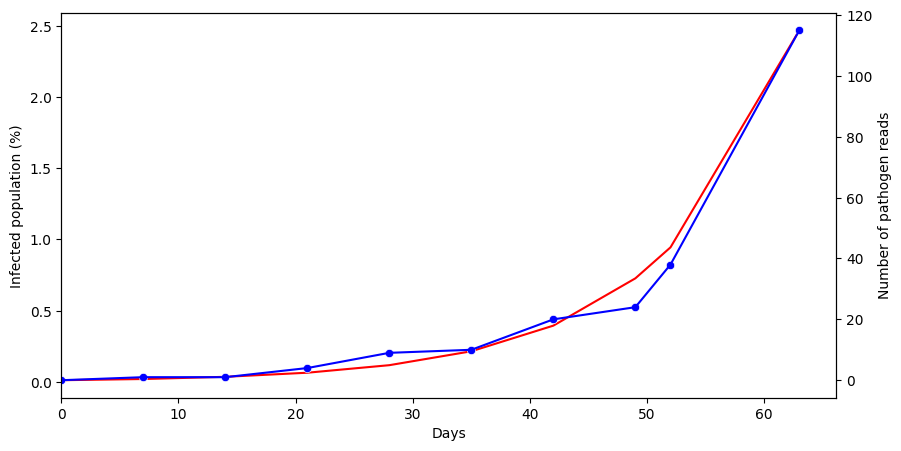

In [67]:
# plot the number of pathogen reads in the samples
# plot the calculated abundance of the pathogen in the samples on the same plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=background_df, x="Days", y="Infected", color="red")
plt.ylabel("Infected population (%)")
plt.twinx()
sns.lineplot(data=background_df, x="Days", y="Reads", color="blue")
plt.xlabel("Days")
plt.ylabel("Number of pathogen reads")
# add points to the plot
sns.scatterplot(data=background_df, x="Days", y="Reads", color="blue")
plt.xlim(0, )
plt.show()




Sample background data and pathogen abundance data using seqtk:

In [ ]:
# export the table
if test_subsampling:
    background_df.to_csv("results/subsampling_table_test.tsv", index=False)
else:
    background_df.to_csv("results/subsampling_table.tsv", index=False)
